#IMPORTS

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


DATA EXTRACTION AND DATA ANALYSIS

In [ ]:
df = pd.read_csv(r"C:\Users\Arnav\Documents\python\MLCOE\Restaurant_revenue (1).csv")
print("Dataset was loaded successfully")
print(f"Shape: {df.shape}")
df.head()
print("\nBasic Statistics:")
df.describe()

#Graphs and Visualisations

In [ ]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(df['Reviews'], bins=25, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Distribution of Restaurant Ratings')
plt.xlabel('Restaurant Rating (1-5)')
plt.ylabel('Number of Restaurants')
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
plt.hist(df['Number_of_Customers'], bins=20, color='lightcoral', edgecolor='black', alpha=0.7)
plt.title('Distribution of Number of customers')
plt.xlabel('Service Quality (1-5)')
plt.ylabel('Number of Restaurants')
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
plt.scatter(df['Monthly_Revenue'], df['Reviews'], alpha=0.6, color='gold')
plt.title('Monthly Revenue vs Rating')
plt.xlabel('Restaurant Revenue (1-5)')
plt.ylabel('Restaurant Rating (1-5)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Create New Features

In [ ]:
df_features = df.copy()


if 'Food_Quality' not in df_features.columns:
    df_features['Food_Quality'] = 1 + 4 * (df_features['Average_Customer_Spending'] - df_features['Average_Customer_Spending'].min()) / (df_features['Average_Customer_Spending'].max() - df_features['Average_Customer_Spending'].min())
    df_features['Food_Quality'] = np.clip(df_features['Food_Quality'], 1, 5)

if 'Service_Quality' not in df_features.columns:
    df_features['Service_Quality'] = 1 + 4 * (df_features['Monthly_Revenue'] - df_features['Monthly_Revenue'].min()) / (df_features['Monthly_Revenue'].max() - df_features['Monthly_Revenue'].min())
    df_features['Service_Quality'] = np.clip(df_features['Service_Quality'], 1, 5)

# 1: Overall quality score (combination of food and service)
df_features['overall_quality'] = (df_features['Food_Quality'] + df_features['Service_Quality']) / 2
print("Created overall_quality feature")

# 2: Value for money (spending vs price ratio)
df_features['value_for_money'] = df_features['Average_Customer_Spending'] / (df_features['Menu_Price'] + 1)
print("Created value_for_money feature")

# 3: Customer loyalty indicator (customers vs spending)
df_features['customer_loyalty'] = df_features['Number_of_Customers'] * np.log1p(df_features['Average_Customer_Spending'])
print("Created customer_loyalty feature")

# 4: Service efficiency (customers served per service quality point)
df_features['service_efficiency'] = df_features['Number_of_Customers'] / (df_features['Service_Quality'] + 1)
print("Created service_efficiency feature")

# 5: Food value score (food quality vs menu price)
df_features['food_value_score'] = df_features['Food_Quality'] / (df_features['Menu_Price'] / 10 + 1)
print("Created food_value_score feature")

# 6: Promotion effectiveness on quality
df_features['promotion_quality_boost'] = df_features['Promotions'] * df_features['overall_quality']
print("Created promotion_quality_boost feature")

# 7: Revenue per customer (business success indicator)
df_features['revenue_per_customer'] = df_features['Monthly_Revenue'] / (df_features['Number_of_Customers'] + 1)
print("Created revenue_per_customer feature")

# 8: Marketing effectiveness
df_features['marketing_per_customer'] = df_features['Marketing_Spend'] / (df_features['Number_of_Customers'] + 1)
print("Created marketing_per_customer feature")

# 9: Quality consistency score
df_features['quality_consistency'] = 5 - abs(df_features['Food_Quality'] - df_features['Service_Quality'])
print("Created quality_consistency feature")

print(f"\nNew dataset shape: {df_features.shape}")
print("New features were created")


if 'Restaurant_Rating' not in df_features.columns:
    if 'Reviews' in df_features.columns:
        df_features['Restaurant_Rating'] = 1 + (df_features['Reviews'] / 25)  # Convert 0-99 to 1-5 scale
        df_features['Restaurant_Rating'] = np.clip(df_features['Restaurant_Rating'], 1, 5)
        print("Created Restaurant_Rating from Reviews")
    else:
        print("Restaurant reviews were not found")

# Select features for training (excluding target variable)
feature_columns = [
    'Number_of_Customers', 'Menu_Price', 'Marketing_Spend', 
    'Average_Customer_Spending', 'Promotions', 'Monthly_Revenue',
    'Service_Quality', 'Food_Quality', 'overall_quality', 
    'value_for_money', 'customer_loyalty', 'service_efficiency',
    'food_value_score', 'promotion_quality_boost', 'revenue_per_customer',
    'marketing_per_customer', 'quality_consistency'
]

X = df_features[feature_columns]
y = df_features['Restaurant_Rating']  # TARGET: Restaurant Rating

print(f"Features selected: {len(feature_columns)}")
print("Feature names:", feature_columns)
print(f"Target variable: Restaurant_Rating")


Train-test split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Data scaled successfully")

Random Forest CLassifier and Feature Importance

In [ ]:
rf_model = RandomForestRegressor(
    n_estimators=150,
    random_state=42,
    max_depth=12,
    min_samples_split=3,
    min_samples_leaf=2)

rf_model.fit(X_train, y_train)
print("Random Forest model trained")

# Make predictions
rf_predictions = rf_model.predict(X_test)

# Clip predictions to valid rating range (1-5)
rf_predictions = np.clip(rf_predictions, 1, 5)

# Calculate metrics
rf_mse = mean_squared_error(y_test, rf_predictions)
rf_rmse = np.sqrt(rf_mse)
rf_mae = mean_absolute_error(y_test, rf_predictions)
rf_r2 = r2_score(y_test, rf_predictions)

print(f"Random Forest Results:")
print(f"RMSE: {rf_rmse:.4f}")
print(f"MAE: {rf_mae:.4f}")
print(f"R² Score: {rf_r2:.4f}")

# Cell 11: Feature importance analysis for rating prediction
print("=== FEATURE IMPORTANCE ANALYSIS FOR RATING PREDICTION ===")

# Get feature importance
feature_importance = rf_model.feature_importances_
importance_df = pd.DataFrame({
    'feature': feature_columns,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print("Feature Importance Rankings for Rating Prediction:")
print(importance_df)

# Plot feature importance
plt.figure(figsize=(12, 10))
plt.title('Feature Importance - Restaurant Rating Prediction (Random Forest)')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

Neural Networks 

In [ ]:
model = keras.Sequential([
    layers.Dense(256, activation='relu', input_shape=(len(feature_columns),)),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(1, activation='sigmoid')  ])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

print("Neural Network Architecture for Rating Prediction:")
model.summary()

# Scale target to 0-1 range for better neural network training
y_train_scaled = (y_train - 1) / 4  # Scale from 1-5 to 0-1
y_test_scaled = (y_test - 1) / 4

history = model.fit(
    X_train_scaled, y_train_scaled,
    epochs=120,
    batch_size=32,
    validation_split=0.2,
    verbose=1,
    shuffle=True
)

print("Neural network training done")

# Make predictions and scale back to 1-5 range
nn_predictions_scaled = model.predict(X_test_scaled).flatten()
nn_predictions = (nn_predictions_scaled * 4) + 1  # Scale back from 0-1 to 1-5

nn_predictions = np.clip(nn_predictions, 1, 5)

# Calculate metrics
nn_mse = mean_squared_error(y_test, nn_predictions)
nn_rmse = np.sqrt(nn_mse)
nn_mae = mean_absolute_error(y_test, nn_predictions)
nn_r2 = r2_score(y_test, nn_predictions)

print(f"Neural Network Results:")
print(f"RMSE: {nn_rmse:.4f}")
print(f"MAE: {nn_mae:.4f}")
print(f"R² Score: {nn_r2:.4f}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0891 - mae: 0.2610 - val_loss: 0.0785 - val_mae: 0.2441
Epoch 2/120
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0838 - mae: 0.2516 - val_loss: 0.0788 - val_mae: 0.2449
Epoch 3/120
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0841 - mae: 0.2519 - val_loss: 0.0796 - val_mae: 0.2465
Epoch 4/120
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0818 - mae: 0.2478 - val_loss: 0.0781 - val_mae: 0.2432
Epoch 5/120
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0833 - mae: 0.2505 - val_loss: 0.0809 - val_mae: 0.2469
Epoch 6/120
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0841 - mae: 0.2541 - val_loss: 0.0799 - val_mae: 0.2461
Epoch 7/120
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0839 - mae: 0.2515 - val_loss: 0.0799 - val_mae: 0.2460
Epoch 8/120
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0826 - mae: 0.2493 - val_loss: 0.0819 - val_mae: 0.2493
Epoch 9/120
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0817 - ma

Training History Visualisation

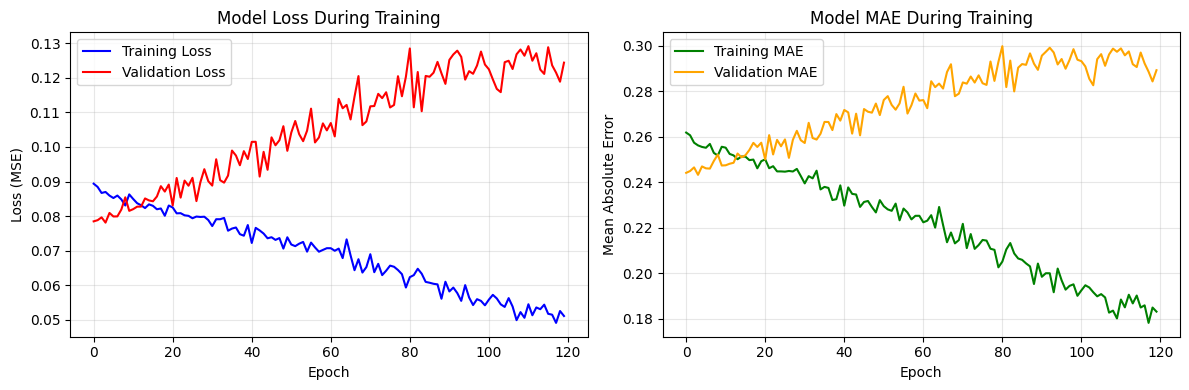

In [13]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.title('Model Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE', color='green')
plt.plot(history.history['val_mae'], label='Validation MAE', color='orange')
plt.title('Model MAE During Training')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


Model Visual Comparisions

Sample rating predictions comparison:
   Actual_Rating  Random_Forest  Neural_Network
0           1.76       2.591646        1.688745
1           1.40       2.811645        2.948330
2           2.84       3.158024        3.716477
3           1.20       2.782905        2.726010
4           2.76       3.317237        4.229826
5           4.64       2.852418        1.748279
6           4.00       2.557956        2.888726
7           1.80       3.062173        3.717305
8           1.40       3.110840        3.406957
9           1.96       2.946597        3.398886


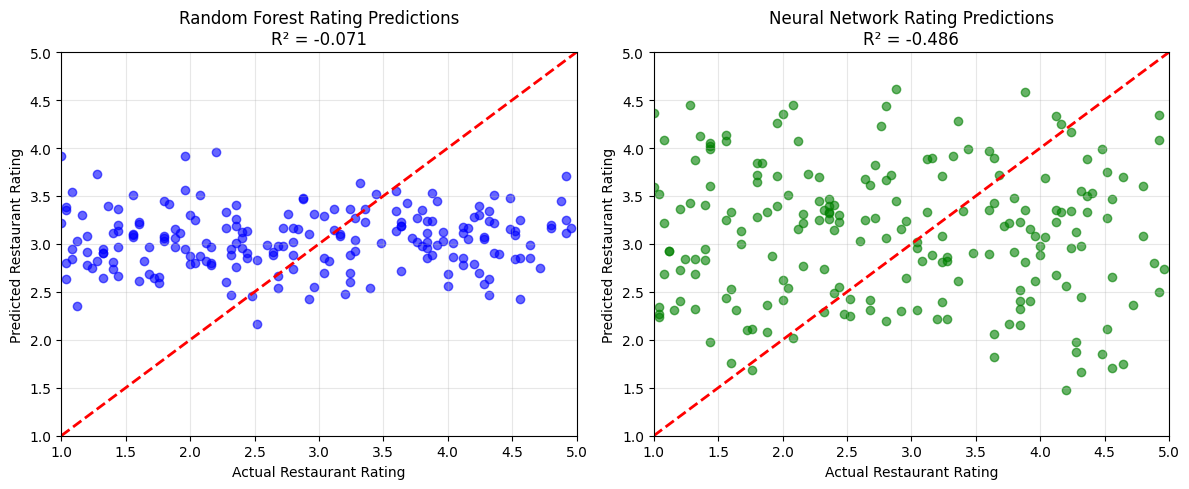

In [14]:
comparison_df = pd.DataFrame({
    'Actual_Rating': y_test.values,
    'Random_Forest': rf_predictions,
    'Neural_Network': nn_predictions
})

print("Sample rating predictions comparison:")
print(comparison_df.head(10))

# Plot predictions vs actual
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_test, rf_predictions, alpha=0.6, color='blue')
plt.plot([1, 5], [1, 5], 'r--', lw=2)
plt.xlabel('Actual Restaurant Rating')
plt.ylabel('Predicted Restaurant Rating')
plt.title(f'Random Forest Rating Predictions\nR² = {rf_r2:.3f}')
plt.xlim(1, 5)
plt.ylim(1, 5)
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.scatter(y_test, nn_predictions, alpha=0.6, color='green')
plt.plot([1, 5], [1, 5], 'r--', lw=2)
plt.xlabel('Actual Restaurant Rating')
plt.ylabel('Predicted Restaurant Rating')
plt.title(f'Neural Network Rating Predictions\nR² = {nn_r2:.3f}')
plt.xlim(1, 5)
plt.ylim(1, 5)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Error analysis

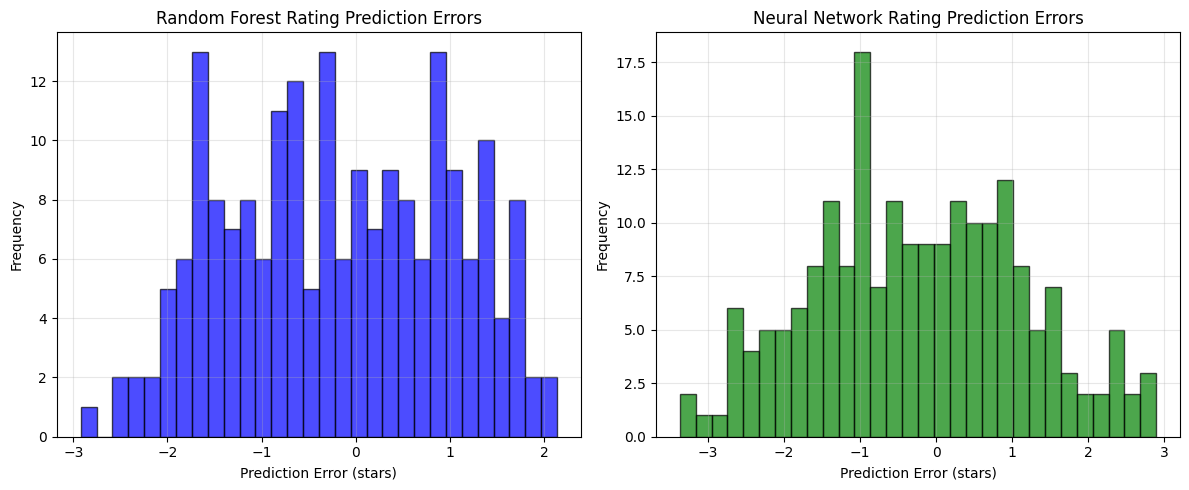

In [15]:
# Calculate errors
rf_errors = y_test - rf_predictions
nn_errors = y_test - nn_predictions

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(rf_errors, bins=30, alpha=0.7, color='blue', edgecolor='black')
plt.title('Random Forest Rating Prediction Errors')
plt.xlabel('Prediction Error (stars)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.hist(nn_errors, bins=30, alpha=0.7, color='green', edgecolor='black')
plt.title('Neural Network Rating Prediction Errors')
plt.xlabel('Prediction Error (stars)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Final Model Comparision

In [ ]:
results_summary = pd.DataFrame({
    'Model': ['Random Forest', 'Neural Network'],
    'RMSE': [rf_rmse, nn_rmse],
    'MAE': [rf_mae, nn_mae],
    'R² Score': [rf_r2, nn_r2]})

print("Rating Prediction Model Performance Comparison:")
print(results_summary.round(4))

# Determine best model
if rf_r2 > nn_r2:
    best_model = "Random Forest"
    best_score = rf_r2
else:
    best_model = "Neural Network"
    best_score = nn_r2

print(f"\n🏆 Best performing model: {best_model}")
print(f"Best R² Score: {best_score:.4f}")


Rating Prediction Model Performance Comparison:
            Model    RMSE     MAE  R² Score
0   Random Forest  1.1809  1.0102   -0.0706
1  Neural Network  1.3911  1.1563   -0.4859

🏆 Best performing model: Random Forest
Best R² Score: -0.0706


Predict  Restaurannt rating detecting

In [ ]:
def predict_restaurant_rating(customers, menu_price, marketing_spend, avg_spending, promotions, revenue, service_quality, food_quality):
    """
    Predict restaurant rating based on input parameters
    """
    # Create feature engineering for new input
    overall_quality = (food_quality + service_quality) / 2
    value_for_money = avg_spending / (menu_price + 1)
    customer_loyalty = customers * np.log1p(avg_spending)
    service_efficiency = customers / (service_quality + 1)
    food_value_score = food_quality / (menu_price / 10 + 1)
    promotion_quality_boost = promotions * overall_quality
    revenue_per_customer = revenue / (customers + 1)
    marketing_per_customer = marketing_spend / (customers + 1)
    quality_consistency = 5 - abs(food_quality - service_quality)
    
    # Create dataframe with all features
    input_data = pd.DataFrame({
        'Number_of_Customers': [customers],
        'Menu_Price': [menu_price],
        'Marketing_Spend': [marketing_spend],
        'Average_Customer_Spending': [avg_spending],
        'Promotions': [promotions],
        'Monthly_Revenue': [revenue],
        'Service_Quality': [service_quality],
        'Food_Quality': [food_quality],
        'overall_quality': [overall_quality],
        'value_for_money': [value_for_money],
        'customer_loyalty': [customer_loyalty],
        'service_efficiency': [service_efficiency],
        'food_value_score': [food_value_score],
        'promotion_quality_boost': [promotion_quality_boost],
        'revenue_per_customer': [revenue_per_customer],
        'marketing_per_customer': [marketing_per_customer],
        'quality_consistency': [quality_consistency] })
    
    # Scale the data
    input_scaled = scaler.transform(input_data)
    
    # Make predictions
    rf_pred = np.clip(rf_model.predict(input_data)[0], 1, 5)
    nn_pred_scaled = model.predict(input_scaled)[0][0]
    nn_pred = np.clip((nn_pred_scaled * 4) + 1, 1, 5)
    avg_pred = (rf_pred + nn_pred) / 2
    
    return rf_pred, nn_pred, avg_pred

In [ ]:
print("Choose your input method:")
print("1. Use sample restaurant data")
print("2. Enter custom restaurant data")

input_choice=int(input("enter choice 1/2"))

if input_choice == 1:
    print("\n Using Sample Restaurant Data for Rating Prediction:")
    
    # Sample restaurant examples
    sample_restaurants = [
        {"name": "Cozy Italian Bistro", "customers": 45, "menu_price": 28.5, "marketing": 8.2, "avg_spend": 32.0, "promotions": 1, "revenue": 350, "service": 4.2, "food": 4.5},
        {"name": "Fast Food Corner", "customers": 85, "menu_price": 15.8, "marketing": 15.0, "avg_spend": 18.5, "promotions": 1, "revenue": 420, "service": 3.5, "food": 3.8},
        {"name": "Luxury Fine Dining", "customers": 25, "menu_price": 45.2, "marketing": 5.5, "avg_spend": 48.0, "promotions": 0, "revenue": 280, "service": 4.8, "food": 4.9},
        {"name": "Family Restaurant", "customers": 55, "menu_price": 22.0, "marketing": 11.8, "avg_spend": 25.5, "promotions": 1, "revenue": 380, "service": 4.0, "food": 4.1}
    ]
    
    for i, restaurant in enumerate(sample_restaurants, 1):
        print(f"\n--- Restaurant {i}: {restaurant['name']} ---")
        print(f"Customers: {restaurant['customers']}")
        print(f"Menu Price: ${restaurant['menu_price']}")
        print(f"Marketing Spend: ${restaurant['marketing']}")
        print(f"Avg Customer Spending: ${restaurant['avg_spend']}")
        print(f"Promotions: {'Yes' if restaurant['promotions'] else 'No'}")
        print(f"Monthly Revenue: ${restaurant['revenue']}")
        print(f"Service Quality: {restaurant['service']}/5")
        print(f"Food Quality: {restaurant['food']}/5")
        
        rf_pred, nn_pred, avg_pred = predict_restaurant_rating(
            restaurant['customers'], restaurant['menu_price'], restaurant['marketing'],
            restaurant['avg_spend'], restaurant['promotions'], restaurant['revenue'],
            restaurant['service'], restaurant['food']
        )
        
        print(f"\Rating Predictions:")
        print(f"Random Forest: {rf_pred:.2f}/5 stars")
        print(f"Neural Network: {nn_pred:.2f}/5 stars")
        print(f"Final Prediction: {avg_pred:.2f}/5 stars")
        print("-" * 50)

elif input_choice == 2:
    print("\nEnter Custom Restaurant Data for Rating Prediction:")
    print("Please enter the needed information")
    
    # Get custom input from user
    try:
        customers = int(input("Number of Customers (10-99): "))
        menu_price = float(input("Average Menu Price ($10-50): "))
        marketing = float(input("Marketing Spend ($0-20): "))
        avg_spend = float(input("Average Customer Spending ($10-50): "))
        promotions = int(input("Promotions (0 for No, 1 for Yes): "))
        revenue = float(input("Monthly Revenue ($50-500): "))
        service_quality = float(input("Service Quality (1-5): "))
        food_quality = float(input("Food Quality (1-5): "))
        
        print(f"\n--- Your Custom Restaurant ---")
        print(f"Customers: {customers}")
        print(f"Menu Price: ${menu_price:.2f}")
        print(f"Marketing Spend: ${marketing:.2f}")
        print(f"Avg Customer Spending: ${avg_spend:.2f}")
        print(f"Promotions: {'Yes' if promotions else 'No'}")
        print(f"Monthly Revenue: ${revenue:.2f}")
        print(f"Service Quality: {service_quality}/5")
        print(f"Food Quality: {food_quality}/5")
        
        rf_pred, nn_pred, avg_pred = predict_restaurant_rating(
            customers, menu_price, marketing, avg_spend, promotions, revenue,
            service_quality, food_quality
        )
        
        print(f"\nRating Predictions for Restaurant:")
        print(f"Random Forest: {rf_pred:.2f}/5 stars")
        print(f"Neural Network: {nn_pred:.2f}/5 stars")
        print(f"Final Prediction: {avg_pred:.2f}/5 stars")
        
    except ValueError:
        print("Invalid input,Enter numbers only.")
    except:
        print("Check your inputs Again")

Choose your input method:
1. Use sample restaurant data
2. Enter custom restaurant data

⭐ Using Sample Restaurant Data for Rating Prediction:

--- Restaurant 1: Cozy Italian Bistro ---
Customers: 45
Menu Price: $28.5
Marketing Spend: $8.2
Avg Customer Spending: $32.0
Promotions: Yes
Monthly Revenue: $350
Service Quality: 4.2/5
Food Quality: 4.5/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step

⭐ Rating Predictions:
Random Forest: 3.05/5 stars
Neural Network: 4.47/5 stars
Final Prediction: 3.76/5 stars
--------------------------------------------------

--- Restaurant 2: Fast Food Corner ---
Customers: 85
Menu Price: $15.8
Marketing Spend: $15.0
Avg Customer Spending: $18.5
Promotions: Yes
Monthly Revenue: $420
Service Quality: 3.5/5
Food Quality: 3.8/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step

⭐ Rating Predictions:
Random Forest: 3.10/5 stars
Neural Network: 3.60/5 stars
Final Prediction: 3.35/5 stars
--------------------------------------------------

--- Restaurant 3: Luxury Fine Dining ---
Cus